### Import all the necessary libraries, including Brian2

In [1]:
from brian2 import *
from brian2tools import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


### Define Utils functions

In [2]:
# this function is only needed to extract the spike phases for further analyses, but not to run the network itself
def phi_distribution(spike_monitor, freq):
    '''
    Takes a Brian2 SpikeMonitor object and outputs a 1D array of phase-of-firing spike times
    with respect to an oscillation with frequency *freq*.
    '''
    bin_time = 1/freq
    phi = []
    for neuron_times in spikes.spike_trains().values():
        aux = []
        for time in neuron_times:
            aux.append(2*pi*(time%bin_time)/bin_time)
        phi.append(aux)
    phi = np.array(phi, dtype=object)
    return phi

### Define the spiking neural network in Brian2

In [3]:
#clear brian scope to reset any past variables
start_scope()

#total size of the network (number of pyramidal cells)
N = 6

#define LIF parameters (from hippocampal neurons: McLelland & Paulsen, 2009 J Phys --> https://doi.org/ckhc2t)
tau_m = 24*ms      # membrane time constant
R_m = 142e6*ohm    # membrane resistance
v_thres = -50*mV   # spiking threshold
v_rest = -65*mV    # resting (and reset) potential
tau_ref = 5*ms     # refractory period
V_0 = -65*mV       # initial state (membrane voltage)

#define global inhibition (gamma) parameters (resembling Fast Spiking Interneurons in hippocampus and cortex)
tau_inh = 5*ms     # decay time constant
g_inh = 0.2*namp   # peak of synaptic inhibitory current

#define after-spike hyperpolarization (AHP) that each neuron will have (as pyramidal cells have in the hippocampus)
tau_ahp = 40*ms    # decay time constant
g_ahp = 0.3*namp   # peak of after-spike hyperpolarizing current

#define theta oscillation parameters (as they are observed in local field potentials within the hippocampus)
I_osc = 40*pA           # amplitude of the current-based oscillation
oscillation_T = 200*ms  # oscillatory period
f = 1/oscillation_T     # oscillatory frequency (default: 5 Hz, i.e., within theta range)

#define stimulus and intrinsic noise parameters
I_s = np.linspace(120, 140, N) * pA   # current-based input levels (linearly spaced)
noise_frac = 0.04    # scaling factor of variance of the Wiener process
v_noise = noise_frac*(v_thres - v_rest)   # variance of the Wiener process as a fraction of (i.e., proportional to) the distance from the resting potential to threshold

#define the model equation that each neuron will follow
eqs = '''
dv/dt = (-(v - v_rest) + R_m*(I_theta + I_s - I_inh - I_ahp))/tau_m + (v_noise/sqrt(tau_m))*xi : volt
I_theta = I_osc*cos(2*pi*f*t - pi) : amp
dI_inh/dt = -I_inh/tau_inh : amp
dI_ahp/dt = -I_ahp/tau_ahp : amp
v_rest : volt
R_m : ohm
tau_m : second
I_s : amp
v_noise : volt
I_osc : amp
f : Hz
'''

#the network is defined as a Brian2 NeuronGroup
encoder = NeuronGroup(N, eqs, threshold = 'v>v_thres', refractory = tau_ref, method = 'euler')

# initialize all the variables
encoder.v = V_0         # initial condition
encoder.I_s = I_s
encoder.R_m = R_m
encoder.tau_m = tau_m
encoder.v_rest = v_rest
encoder.v_noise = v_noise
encoder.I_inh = 0*amp   # initial condition
encoder.I_ahp = 0*amp   # initial condition
encoder.I_osc = I_osc
encoder.f = f

#define connections for global inhibition (all-to-all fast inhibition generating gamma oscillations)
S_inh = Synapses(encoder, encoder, 'w : amp', on_pre='I_inh += w')
S_inh.connect(p = 1)
S_inh.w = g_inh

#define "connections" for after-spike hyperpolarization (each neuron hyperpolarizes itself after a spike to enforce one spike per theta cycle)
S_ahp = Synapses(encoder, encoder, 'w : amp', on_pre='I_ahp += w')
S_ahp.connect('i == j', p = 1)
S_ahp.w = g_ahp

#monitors spiking events and other relevant state variables
trajectories = StateMonitor(encoder, 'v', record=True)
theta = StateMonitor(encoder, 'I_theta', record=True)
inhibition = StateMonitor(encoder, 'I_inh', record=True)
afterhyper = StateMonitor(encoder, 'I_ahp', record=True)
spikes = SpikeMonitor(encoder, variables='v')

### Run the network for an extended period of time (to be able to collect reliable phase-of-firing statistics)

In [4]:
defaultclock.dt = 0.1*ms
total_time = 1000*oscillation_T   # for faster runs, total_time can be reduced to ~100*oscillation_T

run(total_time, report = 'text')

WARNING    "tau_m" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 24. * msecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "R_m" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 142. * Mohm. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "f" is an internal variable of group "neurongroup", but also exists in the run namespace with the value 5. * hertz. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "v_rest" is an internal variable of group "neurongroup", but also exists in the run namespace with the value -65. * mvolt. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    "I_osc" is an internal variable of group "neurongroup", but also exists in the run namespace wit

Starting simulation at t=0. s for a duration of 1. ks
16.473 s (1%) simulated in 10s, estimated 9m 57s remaining.
33.0844 s (3%) simulated in 20s, estimated 9m 45s remaining.
49.7409 s (4%) simulated in 30s, estimated 9m 33s remaining.
66.2275 s (6%) simulated in 40s, estimated 9m 24s remaining.
82.8007 s (8%) simulated in 50s, estimated 9m 14s remaining.
99.3473 s (9%) simulated in 1m 0s, estimated 9m 4s remaining.
115.6119 s (11%) simulated in 1m 10s, estimated 8m 55s remaining.
131.9954 s (13%) simulated in 1m 20s, estimated 8m 46s remaining.
148.5309 s (14%) simulated in 1m 30s, estimated 8m 36s remaining.
165.04 s (16%) simulated in 1m 40s, estimated 8m 26s remaining.
181.5866 s (18%) simulated in 1m 50s, estimated 8m 16s remaining.
198.2126 s (19%) simulated in 2m 0s, estimated 8m 5s remaining.
214.581 s (21%) simulated in 2m 10s, estimated 7m 56s remaining.
231.1158 s (23%) simulated in 2m 20s, estimated 7m 46s remaining.
247.6661 s (24%) simulated in 2m 30s, estimated 7m 36s re

### Extract the phases-of-firing for all neurons

In [5]:
phis = phi_distribution(spikes, f)

In [6]:
#uncomment and run this cell if you want to save the phase-of-firing data
#np.save('phis.npy', phis)

In [7]:
#uncomment and run this cell if you want to load previously saved phase-of-firing data
#phis = np.load('phis.npy', allow_pickle=True)

### Compute and plot phase-of-firing distributions (histograms) for all neurons

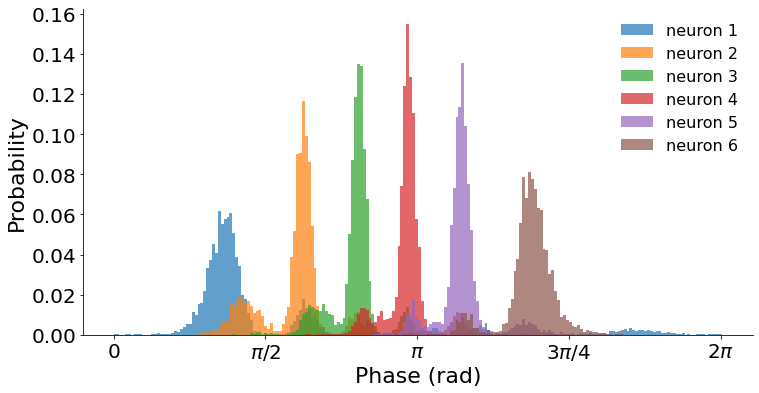

In [8]:
plt.figure(figsize=(12,6))
for neuron in np.arange(N)[::-1]:
    weights_hist = np.ones_like(phis[neuron]) / len(phis[neuron])
    plt.hist(phis[neuron], bins=np.arange(0, 2*np.pi+0.03, 0.03), label="neuron {}".format(N-neuron), alpha=.7, weights=weights_hist)
    plt.xticks(np.arange(0, 5*np.pi/2, np.pi/2), [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/4$", r"$2\pi$"], fontsize=20)
    plt.yticks(fontsize=20)
plt.xlabel("Phase (rad)", size=22)
plt.ylabel("Probability", size=22)
plt.legend(fontsize=16, loc='upper right', frameon=False)
sns.despine()
plt.show()

### Plot other informative figures to make sure the network is behaving as expected

WARNING    /home/albert/.local/lib/python3.8/site-packages/brian2tools/plotting/data.py:59: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  axes.plot(spike_times/time_unit, spike_indices, '.', **kwds)
 [py.warnings]
  axes.plot(spike_times/time_unit, spike_indices, '.', **kwds)



(0.0, 1.0)

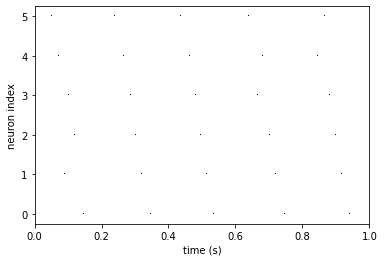

In [9]:
plot_raster(spikes.i, spikes.t, time_unit=second, marker=',', color='k')
plt.xlim(0,1)

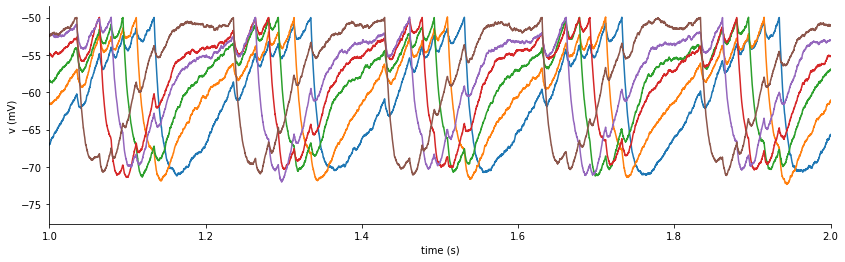

In [10]:
plt.figure(figsize=(14,4))
brian_plot(trajectories, time_unit=second)
plt.xlim(1,2)
sns.despine()